In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

# 1. Project input to patches

입력 이미지를 패치로 나누기

batch 사이즈가 8이고, 3채널, 각 채널이 224x224 이미지라는 것을 의미

`rearrange()` 설명
- 'b': batch size
- 'c': 채널 수
- '(h, s1)': 높이를 's1' 크기의 패치로 나눈다.
- '(w s2)': 너비를 's2' 크기의 패치로 나눈다.

In [ ]:
## input ##
x = torch.randn(8, 3, 224, 224)
print('x :', x.shape)

patch_size = 16 # 16x16 pixel patch
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)',   # reshape 과정
                    s1=patch_size, s2=patch_size)
print('patches :', patches.shape)

x : torch.Size([8, 3, 224, 224])
patches : torch.Size([8, 196, 768])


`nn.Conv2d()`
- in_channels: 입력 이미지의 채널 수
- emb_size: 출력 채널 수
- kernel_size: 커널의 크기
- stride: 필터의 이동 간격

In [ ]:
patch_size = 16
in_channels = 3
emb_size = 768 # channel * patch_size * patch_size = 패치의 임베딩 크기

# 입력 이미지에 대한 2차원 Convolution 연산을 수행
projection = nn.Sequential(
    nn.Conv2d(in_channels, emb_size,
              kernel_size=patch_size, stride=patch_size), # torch.Size([8, 768, 14, 14])
    Rearrange('b e (h) (w) -> b (h w) e'))

summary(projection, x.shape[1:], device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 2.30
Params size (MB): 2.25
Estimated Total Size (MB): 5.12
----------------------------------------------------------------


# 2. Patches Embedding

patches에 class token과 positional embedding을 넣어줍니다.


class token은 어떤 클래스인지 학습하기 위한 파라미터이고,
positional은 패치가 어떤 위치에 있는지 알기 위한 학습 가능한 파라미터입니다.


projection(x)
- x를 사용하여 패치로 나누고, 각 패치를 임베딩하는 과정 수행

projected_x
- shape가 (8. 196. 768)일 것이다.
- 196은 img_size // patch_size의 제곱에 해당

`cls_token`
- nn.Parameter를 사용하여 생성된 파라미터
- (1. 1. 768)의 shape을 가질 것
- 클래스 토큰

`positions`
- nn.Parameter를 사용하여 생성된 파라미터
- (197, 768)의 shape를 가질 것
    - 197은 patch의 개수에 1을 더한 것으로 마지막에 추가된 1은 전체 이미지의 위치를 나타내는 위치 인코딩을 위한 것
- 위치 인코딩을 위한 파라미터


In [ ]:
emb_size = 768
img_size = 224
patch_size = 16

# 이미지를 패치사이즈로 나누고 flatten
projected_x = projection(x)
print('Projected X shape :', projected_x.shape) # 배치 사이즈, 높이x너비, 출력 채널 수 (768)

# cls_token과 pos encoding Parameter 정의
cls_token = nn.Parameter(torch.randn(1,1, emb_size))
positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))
print('Cls Shape :', cls_token.shape, ', Pos Shape :', positions.shape)

# cls_token을 반복하여 배치사이즈의 크기와 맞춰줌
batch_size = 8
cls_tokens = repeat(cls_token, '() n e -> b n e', b=batch_size)
print('Repeated Cls shape :', cls_tokens.shape)

# cls_token과 projected_x를 concatenate
cat_x = torch.cat([cls_tokens, projected_x], dim=1)

# position encoding을 더해줌
cat_x += positions
print('output : ', cat_x.shape)

Projected X shape : torch.Size([8, 196, 768])
Cls Shape : torch.Size([1, 1, 768]) , Pos Shape : torch.Size([197, 768])
Repeated Cls shape : torch.Size([8, 1, 768])
output :  torch.Size([8, 197, 768])


이를 클래스 형태로 만들어주었다.

초기화 단계 `__init__`


1. 프로젝션 계층
    - 2D convolution layers로, 입력 이미지를 패치 크기로 나누고 각 패치를 임베딩 크기로 변환
    - Rearrange()로 텐서 모양으로 (batch_size, num_patches, emb_size)로 재구성
2. 클래스 토큰과 위치 인코딩
    - cls_token: 클래스 토큰으로 사용되는 파라미터 (1, 1, 768)
    - positions: 위치 인코딩을 위한 파라미터 ((img_size // patch_size)**2 + 1, 768)

forward() : 입력 텐서를 받아 패치 임베딩과 위치 인코딩을 수행

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16,
                 emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'))
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions

        return x

PE = PatchEmbedding()
summary(PE, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 2.30
Params size (MB): 2.25
Estimated Total Size (MB): 5.12
----------------------------------------------------------------


# 3. Multi Head Attention (MHA)
패치들에 대해 self-attention 메커니즘을 적용


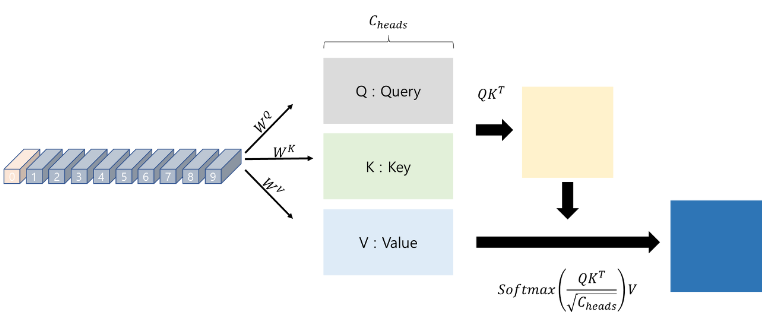

**Multi Head Attention의 준비 과정**



주어진 이미지를 Patch Embedding으로 변환하고, 각 패치를 attention key, query, value으로 변환한 후, 이를 Multi Head 형태로 재구성합니다.


In [ ]:
emb_size = 768
num_heads = 8 # Multi head attention의 헤드 수

# 선형 변환 레이어 정의
keys = nn.Linear(emb_size, emb_size)
queries = nn.Linear(emb_size, emb_size)
values = nn.Linear(emb_size, emb_size)
print(keys, queries, values)

# 입력 텐서 변환
x = PE(x)
print(queries(x).shape) # batch, n, emb_size

# Multi Head Attention 준비
queries = rearrange(queries(x), "b n (h d) -> b h n d", h=num_heads) # -> batch, head, n, emb_size/head
keys = rearrange(keys(x), "b n (h d) -> b h n d", h=num_heads)
values  = rearrange(values(x), "b n (h d) -> b h n d", h=num_heads)

print('shape :', queries.shape, keys.shape, values.shape)

Linear(in_features=768, out_features=768, bias=True) Linear(in_features=768, out_features=768, bias=True) Linear(in_features=768, out_features=768, bias=True)
torch.Size([8, 197, 768])
shape : torch.Size([8, 8, 197, 96]) torch.Size([8, 8, 197, 96]) torch.Size([8, 8, 197, 96])


In [ ]:
# Queries * Keys
energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
print('energy :', energy.shape)

# Get Attention Score
scaling = emb_size ** (1/2)
att = F.softmax(energy/scaling, dim=-1)
print('att :', att.shape)

# Attention Score * values
out = torch.einsum('bhal, bhlv -> bhav ', att, values)
print('out :', out.shape)

# Rearrage to emb_size
out = rearrange(out, "b h n d -> b n (h d)")
print('out2 : ', out.shape)

energy : torch.Size([8, 8, 197, 197])
att : torch.Size([8, 8, 197, 197])
out : torch.Size([8, 8, 197, 96])
out2 :  torch.Size([8, 197, 768])


1. Key,Query, Value는 모두 같은 값은 input으로 받고
2. Linear layer를 통과하여 self-attention이 적용된 후 ,
3. 스케일링되고,
4. value와의 연산 후 input 형태와 동일하게 reshape해주어 아웃풋으로 나온다.

해당 과정을 클래스로 묶으면 아래와 같다.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


x = torch.randn(8, 3, 224, 224)
PE = PatchEmbedding()
x = PE(x)
print(x.shape)
MHA = MultiHeadAttention()
summary(MHA, x.shape[1:], device='cpu')

torch.Size([8, 197, 768])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 197, 2304]       1,771,776
           Dropout-2          [-1, 8, 197, 197]               0
            Linear-3             [-1, 197, 768]         590,592
Total params: 2,362,368
Trainable params: 2,362,368
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.58
Forward/backward pass size (MB): 6.99
Params size (MB): 9.01
Estimated Total Size (MB): 16.57
----------------------------------------------------------------


# 4. Transformer Encoder Block

아래 그림처럼 하나의 블럭으로 만들기 위해,
MLP(Feed forward)블록을 만들어주고, MHA와 하나로 묶어준다.

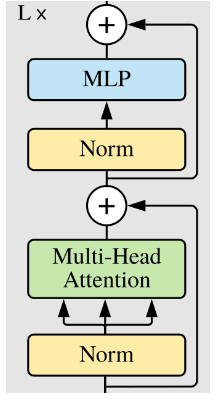

- `ResidualAdd`
    - 잔차 연결 구현
- `FeedForwardBlock`
    - 2개의 선형 레이어와 비선형 활성화 함수(GELU)로 구성된 피드포워드 신경망
    - 입력 임베딩 크기(emb_size)를 확장(expansion*expansion)하고, 활성화 함수와 dropout을 적용한 후, 다시 원래 크기로 축소
- `TransformerEncoderBlock`
    - Transformer의 EncoderBlock을 정의한다.
    - 2개의 잔차 연결 블록으로 구성
        1. 첫 번째 블록
            - Layer Normalization
            - Multi-head attention
            - Dropout
        2. 두 번째 블록
            - Layer Normalization
            - FeedForwardBlock
            - Dropout
    

In [ ]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

x = torch.randn(8, 3, 224, 224)
x = PE(x) # 패치 임베딩
x = MHA(x) # Multi-Head Attention
TE = TransformerEncoderBlock() # Tranasformer Encoder 수행
summary(TE, x.shape[1:], device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1             [-1, 197, 768]           1,536
            Linear-2            [-1, 197, 2304]       1,771,776
           Dropout-3          [-1, 8, 197, 197]               0
            Linear-4             [-1, 197, 768]         590,592
MultiHeadAttention-5             [-1, 197, 768]               0
           Dropout-6             [-1, 197, 768]               0
       ResidualAdd-7             [-1, 197, 768]               0
         LayerNorm-8             [-1, 197, 768]           1,536
            Linear-9            [-1, 197, 3072]       2,362,368
             GELU-10            [-1, 197, 3072]               0
          Dropout-11            [-1, 197, 3072]               0
           Linear-12             [-1, 197, 768]       2,360,064
          Dropout-13             [-1, 197, 768]               0
      ResidualAdd-14             [-1, 1

# 5. 마지막으로 다 묶어서 ViT 빌드

classification을 위한 ClassificationHead 만들어 모델의 마지막 단에 넣어준다.

In [ ]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes))

class ViT(nn.Sequential):
    def __init__(self,
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19